# Logistic Regression

In [405]:
import numpy as np
import scipy.optimize
import scipy.special
import sklearn.datasets
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
def load_iris_binary():
    D, L = sklearn.datasets.load_iris()['data'].T, sklearn.datasets.load_iris()['target']
    D = D[:, L != 0] # remove setosa from D
    L = L[L!=0] # remove setosa from L
    L[L==2] = 0 # We assign label 0 to virginica (was label 2)
    return D, L
def load_iris():
    D, L = sklearn.datasets.load_iris()['data'].T, sklearn.datasets.load_iris()['target']
    return D, L

## Implementation of L-BFGS algorithm

I define an example function f(x)

In [406]:
def f(x):
    y = x[0]
    z = x[1]
    return (y+3)**2 + np.sin(y) + (z+1)**2

Now i call the funcion of scipy.optimize to apply the L-BFGS algorithm. With the parameter approx_grad=True i am saying that the gradient is automatically obtained through finite differences method

In [407]:
x, f, d = scipy.optimize.fmin_l_bfgs_b(func=f, x0=np.zeros(2), approx_grad = True, iprint = 0)

In [408]:
print('Point of minimum: %s'%(x))

Point of minimum: [-2.57747138 -0.99999927]


In [409]:
print('Value of the minimum: %s'%(f))

Value of the minimum: -0.3561430123647649


In [410]:
print('Number of iterations: %s'%(d['funcalls']))

Number of iterations: 21


By passing an explicit approximation of the gradient:

In [411]:
def f_grad(x):
    y = x[0]
    z = x[1]
    grad_y = 2*(y+3) + np.cos(y)
    grad_z = 2*(z+1)
    val = (y+3)**2 + np.sin(y) + (z+1)**2
    return val, np.array([grad_y,grad_z])

In [412]:
x, f, d = scipy.optimize.fmin_l_bfgs_b(func=f_grad, x0=np.zeros(2), approx_grad = False, iprint = 0)

In [413]:
print('Point of minimum: %s'%(x))

Point of minimum: [-2.57747137 -0.99999927]


In [414]:
print('Value of the minimum: %s'%(f))

Value of the minimum: -0.3561430123647611


In [415]:
print('Number of iterations: %s'%(d['funcalls']))

Number of iterations: 7


With this method the algorithm only performs 7 iterations instead of 21 with the same result for minimum!

## Binary Logistic Regression

In [416]:
def split_db_2to1(D, L, seed=0):
    nTrain = int(D.shape[1]*2.0/3.0) # 2/3 of the dataset D are used for training, 1/3 for validation
    np.random.seed(seed)
    idx = np.random.permutation(D.shape[1]) # take a random array of 150 elements, each element is 0<x<=149 (np.arange(150))
    idxTrain = idx[0:nTrain] # first 100 are indices of training samples 
    idxTest = idx[nTrain:] # remaining 50 are indices of validation samples
    DTR = D[:, idxTrain] # D for training
    DTE = D[:, idxTest] # D for validation
    LTR = L[idxTrain] # L for training
    LTE = L[idxTest] # L for validation
    return (DTR, LTR), (DTE, LTE)

In [417]:
D, L = load_iris_binary()
(DTR, LTR), (DTE, LTE) = split_db_2to1(D, L)

In the dataset there are only samples belonging to class virginica and versicolor

We want to optimize the function $J(w,b) = \frac{\lambda}{2}||w||^2 + \frac{1}{n}\sum_{i=1}^{n} log(1+e^{-z_i (w^T x_i + b)})$ with 
 $ z_i =
  \begin{cases}
    1       & \quad \text{if } c_i = 1 \\
    -1  & \quad \text{if } c_i = 0
  \end{cases}
 $

In [418]:
class logRegClass:
    def __init__(self, DTR, LTR, l):
        self.DTR = DTR
        self.LTR = LTR
        self.l = l
        self.D = DTR.shape[0] # dimensionality of features space
        self.K = len(set(LTR)) # number of classes
        self.N = DTR.shape[1]
        
    def __compute_zi(self, ci):
        return 2*ci-1
    
    def __compute_T(self):
        T = np.zeros(shape=(self.K,self.N))
        for i in range(DTR.shape[1]):
            label_xi = self.LTR[i]
            t = []
            for j in range(3):
                if j==label_xi:
                    t.append(1)
                else:
                    t.append(0)
            T[:,i] = t
        return T
            
    
    def logreg_obj(self, v): # still works if DTR is one sample only? yes but it must be of shape (4,1)
        w, b = v[0:-1], v[-1]
        J = l/2*(np.linalg.norm(w)**2)
        summary = 0
        for i in range(self.DTR.shape[1]):
            xi = self.DTR[:,i:i+1]
            ci = self.LTR[i]
            zi = self.__compute_zi(ci)
            summary += np.logaddexp(0,-zi*(np.dot(w.T,xi)+b))
        J += (1/self.DTR.shape[1]) * summary
        return J
    def logreg_multiclass_obj(self, v):
        W, b = v[0:D*K], v[D*K:] # W is an array of array w each of shape (D,1)
        W = np.array(W).reshape(D,K)
        b = np.array(b).reshape(K,1)
        S = np.dot(W.T,self.DTR)+b
        Ylog = S - scipy.special.logsumexp(S, axis=0).reshape(1,-1)
        T = self.__compute_T()
        J = self.l/2 * (W*W).sum() - 1/self.N * (T*Ylog).sum()
        return J
        
        

In [419]:
D = 4 # dimensionality of the feature space
l = 1
logRegObj = logRegClass(DTR, LTR, l)
x, f, d = scipy.optimize.fmin_l_bfgs_b(func=logRegObj.logreg_obj, 
                                       x0=np.zeros(DTR.shape[0]+1), 
                                       approx_grad = True, 
                                       iprint = 0)

In [420]:
print('Point of minimum: %s'%(x))

Point of minimum: [-0.11040235 -0.02898702 -0.24787125 -0.14950476  2.31094811]


In [421]:
print('Value of the minimum: %s'%(f))

Value of the minimum: [0.63164362]


In [422]:
print('Number of iterations: %s'%(d['funcalls']))

Number of iterations: 132


Now we can compute the predictions according to the model parameters w,b that we have obtained:

In [423]:
w, b = x[0:-1], x[-1]
S=np.zeros((DTE.shape[1]))
for i in range(DTE.shape[1]):
    xi = DTE[:,i:i+1]
    s = np.dot(w.T,xi)+b
    S[i] = s
LP = S>0
acc = sum(LP == LTE)/len(LTE)
err = 1 - acc
print('Error rate with lambda=%f is: %.1f%%'%(l,err*100))

Error rate with lambda=1.000000 is: 14.7%


## Extra: plot the decision function of LR

Firstly i train the LR on a 2-features dataset

In [424]:
DTE_2f = DTE[0:2,:] # take only the first 2 features of. DTR, DTE
DTR_2f = DTR[0:2, :]
D = 4 
l = 10**-6
logRegObj = logRegClass(DTR_2f, LTR, l)
x, f, d = scipy.optimize.fmin_l_bfgs_b(func=logRegObj.logreg_obj, 
                                       x0=np.zeros(DTR_2f.shape[0]+1), 
                                       approx_grad = True, 
                                       iprint = 0)
w, b = x[0:-1], x[-1]
S=np.zeros((DTE_2f.shape[1]))
for i in range(DTE_2f.shape[1]):
    xi = DTE_2f[:,i:i+1]
    s = np.dot(w.T,xi)+b
    S[i] = s
LP = S>0

### First way: using `plt.contourf`

I have to build a huge test dataset using a meshgrid, then i use the function `plt.contourf` to obtain the plot of the decision function. The decision function is something that, given ($x_i$,$w$,$b$) returns a score $s_i$. Once that we have computed the score we have to choose a value as threshold $t$ so that: $w_i^{T}x_i + b \gtrless t$. The value of is put to 0  to compute LP in the block above. We can pass different t values to the `contourf` function using the `levels` parameter.

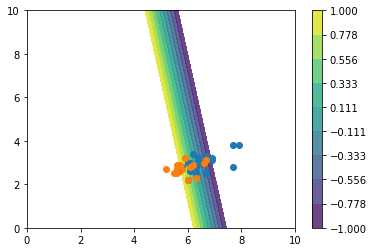

In [425]:
x_test, y_test = np.linspace(0,10,100),np.linspace(0,10,100)
x_grid, y_grid = np.meshgrid(x_test, y_test, indexing='ij')
x_g, y_g = x_grid.flatten(), y_grid.flatten()
x_g, y_g = x_g.reshape((len(x_g), 1)), y_g.reshape((len(y_g), 1))
grid = np.hstack((x_g, y_g)).T # big TEST dataset
# Find scores for each generated sample
S=np.zeros((grid.shape[1]))
for i in range(grid.shape[1]):
    xi = grid[:,i:i+1]
    s = np.dot(w.T,xi)+b
    S[i] = s
surface=plt.contourf(x_grid, y_grid, S.reshape(x_grid.shape), alpha=0.8, levels=np.linspace(-1,1,10))
plt.colorbar(surface)
for class_value in range(2):
    plt.scatter(DTE_2f[0, LTE==class_value], DTE_2f[1, LTE==class_value])
# show the plot
plt.show()

### Second way: computing analytically the decision function

From $w_i^{T}x_i + b = t$ we get (for a 2-features problem) $t = w_1x_1 + w_2x_2 +b$. The decision function is the line $x_2 = mx_1 + c$. With $t=0$ and, for example, $x_1=0$ we have $x_2 = c = -\frac{b}{w_2}$. For the gradient $m$ we consider two points on the decision boundary: https://scipython.com/blog/plotting-the-decision-boundary-of-a-logistic-regression-model/

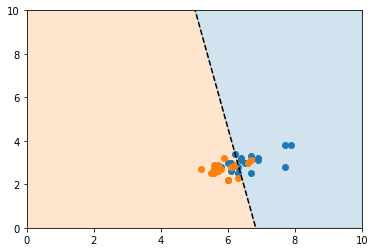

In [426]:
t = 0
c = (t-b)/w[1]
m = -w[0]/w[1]
# Plot the data and the classification with the decision boundary.
xmin, xmax = 0, 10
ymin, ymax = 0, 10
xd = np.array([xmin, xmax])
yd = m*xd + c
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.plot(xd, yd, 'k', ls='--')
plt.fill_between(xd, yd, ymin, color='tab:orange', alpha=0.2)
plt.fill_between(xd, yd, ymax, color='tab:blue', alpha=0.2)
for class_value in range(2):
    plt.scatter(DTE_2f[0, LTE==class_value], DTE_2f[1, LTE==class_value])

## Multiclass Logistic Regression

Load the complete iris dataset (with samples belonging to classes 0,1,2)

In [427]:
D, L = load_iris()
(DTR, LTR), (DTE, LTE) = split_db_2to1(D, L)

Compute matrix of scores S where each column corresponds to the scores of sample $x_i$ for each classes. (Shape of S is (K,n))

First compute the model parameters $W=[w_1,...,w_K]$ and b = $\begin{bmatrix}
           b_1 \\
           \vdots \\
           b_K
         \end{bmatrix}$

In [428]:
### Lambda ###
l = 10**-1
##############
D=4
K=3
logRegObj = logRegClass(DTR, LTR, l)
# logRegObj.logreg_multiclass_obj(np.zeros(D*K+K))
x, f, d = scipy.optimize.fmin_l_bfgs_b(func=logRegObj.logreg_multiclass_obj, 
                                       x0=np.zeros(D*K+K), 
                                       approx_grad = True, 
                                       iprint = 0)

In [429]:
print('Point of minimum (W and b): %s'%(x))

Point of minimum (W and b): [-0.26848886  0.04430232  0.22418597  0.28220245 -0.2456176  -0.03658485
 -0.99553462  0.08006386  0.91547054 -0.41328434 -0.16338961  0.57667411
  4.5322137   1.15688128 -5.68908753]


In [430]:
print('Value of the minimum: %s'%(f))

Value of the minimum: 0.5005906138031373


In [431]:
print('Number of iterations: %s'%(d['funcalls']))

Number of iterations: 1104


In [432]:
Ntest = DTE.shape[1]
SPost = np.zeros(shape=(K,Ntest))
W, b = x[0:D*K], x[D*K:]
W = np.array(W).reshape(D,K)
b = np.array(b).reshape(K,1)
for i in range(Ntest): # for each test sample
    xi = DTE[:,i:i+1]    
    for j in range(K): # for each class
        wc, bc = W[:,j], b[j,:]
        SPost[j,i] = np.dot(wc.T,xi)+bc

LP = np.argmax(SPost,axis=0)
acc = sum(LP == LTE)/len(LTE)
err = 1 - acc
print('Error rate with lambda=%f is: %.1f%%'%(l,err*100))

Error rate with lambda=0.100000 is: 6.0%
